In [45]:
import pandas as pd
import numpy as np
from pyjet import cluster,DTYPE_PTEPM
from sklearn import preprocessing
import tensorflow as tf

# Pre processing

In [46]:
path = '/anomalyvol/data/events_LHCO2020_backgroundMC_Pythia.h5'

In [47]:
df = pd.read_hdf(path,stop=6000) # just read first 10000 events

In [48]:
all_events = df.values

In [49]:
rows = all_events.shape[0]
cols = all_events.shape[1]
data = []

In [50]:
for i in range(rows):
    pseudojets_input = np.zeros(len([x for x in all_events[i][::3] if x > 0]), dtype=DTYPE_PTEPM)
    for j in range(cols // 3):
        if (all_events[i][j*3]>0):
            pseudojets_input[j]['pT'] = all_events[i][j*3]
            pseudojets_input[j]['eta'] = all_events[i][j*3+1]
            pseudojets_input[j]['phi'] = all_events[i][j*3+2]
        pass
    sequence = cluster(pseudojets_input, R=1.0, p=-1)
    jets = sequence.inclusive_jets()
    for k in range(len(jets)):
        jet = []
        jet.append(jets[k].px)
        jet.append(jets[k].py)
        jet.append(jets[k].pz)
        jet.append(jets[k].e)
        data.append(jet)

In [51]:
data = np.array(data)
data.shape

(88434, 4)

In [52]:
# log transform pT
#data[:,3] = np.ma.log(data[:,3]).filled()

In [53]:
data

array([[-1.17658220e+03, -7.79040316e+02,  3.40962660e+02,
         1.45491963e+03],
       [ 6.11088616e+02,  7.16513394e+02,  1.55833044e+03,
         1.87194199e+03],
       [ 4.96094722e+02, -1.87111748e+01,  1.78940558e+03,
         1.85808569e+03],
       ...,
       [ 3.16274379e-01,  3.93550794e-01, -2.93137814e-01,
         5.83816314e-01],
       [-2.34749353e-01, -2.11788008e-01,  1.76074789e+01,
         1.76103172e+01],
       [ 2.00884932e-01, -1.71178173e-03,  9.94645744e+00,
         9.94848597e+00]])

In [54]:
# splitting data
x_train = data[0:int(len(data) * 0.8)]
x_val = data[int(len(data) * 0.8):int(len(data) * 0.9)]
x_test = data[int(len(data) * 0.9):]

In [55]:
# regularize
scaler = preprocessing.StandardScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)

# VAE Model

In [89]:
import keras
from keras.layers import Lambda, Input, Dense, Flatten, Reshape, LeakyReLU
from keras.models import Model, Sequential
from keras import metrics, losses
from keras import backend as K

In [57]:
def sampling(args):
    """
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [58]:
inter_dim_1 = 16
inter_dim_2 = 16
final_dim = 8
latent_dim = 2
input_dim = 4

In [59]:
# encoder
x = Input(shape=(input_dim,))
#x_flat = Flatten()(x)
h1 = Dense(inter_dim_1, activation='relu')(x)

h2 = Dense(inter_dim_2, activation='relu')(h1)
h3 = Dense(final_dim, activation='relu')(h2)
encoding = Dense(latent_dim, activation='tanh')(h3)

In [60]:
# decoder
decoder_h3 = Dense(final_dim, activation='relu')
decoder_h2 = Dense(inter_dim_2, activation='relu')
decoder_h1 = Dense(inter_dim_1, activation='relu')
decoder_mean = Dense(input_dim, activation='linear')

h3_decoded = decoder_h3(encoding)
h2_decoded = decoder_h2(h3_decoded)
h1_decoded = decoder_h1(h2_decoded)
x_decoded_mean = decoder_mean(h1_decoded)
# x_decoded = Reshape(input_shape)(x_decoded_mean)

In [61]:
vae = Model(inputs = x, outputs = x_decoded_mean, name = 'vae')

In [62]:
mse = keras.losses.MeanSquaredError()
def ae_loss(x, y):
    mse_loss = mse(x, y)
    return mse_loss

vae.compile(optimizer='adam', loss=ae_loss)

In [63]:
vae.summary()

Model: "vae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 4)                 0         
_________________________________________________________________
dense_9 (Dense)              (None, 16)                80        
_________________________________________________________________
dense_10 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_11 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_12 (Dense)             (None, 2)                 18        
_________________________________________________________________
dense_13 (Dense)             (None, 8)                 24        
_________________________________________________________________
dense_14 (Dense)             (None, 16)                144     

# Train

In [64]:
from sklearn.model_selection import train_test_split

In [65]:
batch_size = 1000
epochs = 100

In [66]:
x_train.shape

(70747, 4)

In [67]:
my_callbacks = [
    keras.callbacks.EarlyStopping(patience=10)
]

In [68]:
hist = vae.fit(x_train, x_train,
               shuffle=True,
               epochs=epochs,
               batch_size=batch_size,
               validation_data=(x_val, x_val),
               callbacks=my_callbacks)

Train on 70747 samples, validate on 8843 samples
Epoch 1/100
70747/70747 [==============================] - 1s 9us/step - loss: 0.9288 - val_loss: 0.7708
Epoch 2/100
70747/70747 [==============================] - 0s 4us/step - loss: 0.5956 - val_loss: 0.4538
Epoch 3/100
70747/70747 [==============================] - 0s 4us/step - loss: 0.3448 - val_loss: 0.2664
Epoch 4/100
70747/70747 [==============================] - 0s 4us/step - loss: 0.2341 - val_loss: 0.2120
Epoch 5/100
70747/70747 [==============================] - 0s 4us/step - loss: 0.2008 - val_loss: 0.1924
Epoch 6/100
70747/70747 [==============================] - 0s 4us/step - loss: 0.1857 - val_loss: 0.1803
Epoch 7/100
70747/70747 [==============================] - 0s 5us/step - loss: 0.1751 - val_loss: 0.1713
Epoch 8/100
70747/70747 [==============================] - 0s 4us/step - loss: 0.1657 - val_loss: 0.1621
Epoch 9/100
70747/70747 [==============================] - 0s 4us/step - loss: 0.1554 - val_loss: 0.1518
Epoch 

Epoch 78/100
70747/70747 [==============================] - 0s 4us/step - loss: 0.0543 - val_loss: 0.0497
Epoch 79/100
70747/70747 [==============================] - 0s 4us/step - loss: 0.0541 - val_loss: 0.0541
Epoch 80/100
70747/70747 [==============================] - 0s 4us/step - loss: 0.0537 - val_loss: 0.0539
Epoch 81/100
70747/70747 [==============================] - 0s 4us/step - loss: 0.0522 - val_loss: 0.0529
Epoch 82/100
70747/70747 [==============================] - 0s 4us/step - loss: 0.0533 - val_loss: 0.0525
Epoch 83/100
70747/70747 [==============================] - 0s 4us/step - loss: 0.0518 - val_loss: 0.0518
Epoch 84/100
70747/70747 [==============================] - 0s 4us/step - loss: 0.0527 - val_loss: 0.0526
Epoch 85/100
70747/70747 [==============================] - 0s 4us/step - loss: 0.0520 - val_loss: 0.0487
Epoch 86/100
70747/70747 [==============================] - 0s 4us/step - loss: 0.0514 - val_loss: 0.0485
Epoch 87/100
70747/70747 [====================

# Visualization

In [69]:
import matplotlib.pyplot as plt

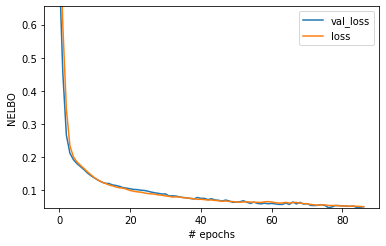

In [70]:
golden_size = lambda width: (width, 2. * width / (1 + np.sqrt(5)))

fig, ax = plt.subplots(figsize=golden_size(6))

hist_df = pd.DataFrame(hist.history)
hist_df.plot(ax=ax)

ax.set_ylabel('NELBO')
ax.set_xlabel('# epochs')

ax.set_ylim(.99*hist_df[1:].values.min(), 
            1.1*hist_df[1:].values.max())
plt.show()

In [71]:
predictions = vae.predict(x_test)

In [72]:
predictions

array([[ 0.0192603 , -0.00767519,  0.11008644, -0.4266879 ],
       [-0.00735722, -0.00952221,  0.52236104, -0.13384502],
       [-0.007497  , -0.01717015,  0.02434671, -0.48309863],
       ...,
       [ 0.01400454, -0.00970425,  0.00399585, -0.4802019 ],
       [ 0.00171684, -0.01375069,  0.03359422, -0.47706252],
       [ 0.0069363 , -0.01263751,  0.02093999, -0.47960532]],
      dtype=float32)

In [73]:
distr = (x_test - predictions) / x_test

In [74]:
px_pred = [row[0] for row in predictions]
py_pred = [row[1] for row in predictions]
pz_pred = [row[2] for row in predictions]
e_pred = [row[3] for row in predictions]

In [75]:
px = [row[0] for row in x_test]
py = [row[1] for row in x_test]
pz = [row[2] for row in x_test]
e = [row[3] for row in x_test]

In [76]:
overall_distr = K.flatten(distr)
overall_pred = K.flatten(predictions)
overall_input = K.flatten(x_test)

(array([  54.,   64.,   60.,   56.,   40.,   57.,   51.,   41.,   60.,
          85.,   88.,  100.,   98.,  106.,  140.,  142.,  150.,  175.,
         283.,  381., 1109., 2667., 2129., 1280., 1083., 1639., 1918.,
        2344.,  999.,  569.,  337.,  241.,  187.,  137.,  137.,  107.,
          94.,  110.,   99.,   74.,   71.,   63.,   51.,   33.,   51.,
          57.,   33.,   44.,   45.]),
 array([-0.1       , -0.09591837, -0.09183673, -0.0877551 , -0.08367347,
        -0.07959184, -0.0755102 , -0.07142857, -0.06734694, -0.06326531,
        -0.05918367, -0.05510204, -0.05102041, -0.04693878, -0.04285714,
        -0.03877551, -0.03469388, -0.03061224, -0.02653061, -0.02244898,
        -0.01836735, -0.01428571, -0.01020408, -0.00612245, -0.00204082,
         0.00204082,  0.00612245,  0.01020408,  0.01428571,  0.01836735,
         0.02244898,  0.02653061,  0.03061224,  0.03469388,  0.03877551,
         0.04285714,  0.04693878,  0.05102041,  0.05510204,  0.05918367,
         0.06326531,  0

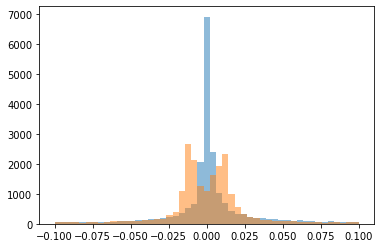

In [77]:
# overall pred vs input
bins = np.linspace(-0.1, 0.1, 50)
plt.hist(overall_input, bins=bins,alpha=0.5)
plt.hist(overall_pred, bins=bins,alpha=0.5)

(array([ 118.,  117.,  133.,  142.,  153.,  161.,  213.,  236.,  225.,
         271.,  370.,  549., 1090., 2362., 9996., 3483., 1489.,  651.,
         519.,  518.,  400.,  340.,  323.,  260.,  230.,  208.,  197.,
         180.,  140.]),
 array([-2.        , -1.86206897, -1.72413793, -1.5862069 , -1.44827586,
        -1.31034483, -1.17241379, -1.03448276, -0.89655172, -0.75862069,
        -0.62068966, -0.48275862, -0.34482759, -0.20689655, -0.06896552,
         0.06896552,  0.20689655,  0.34482759,  0.48275862,  0.62068966,
         0.75862069,  0.89655172,  1.03448276,  1.17241379,  1.31034483,
         1.44827586,  1.5862069 ,  1.72413793,  1.86206897,  2.        ]),
 <a list of 29 Patch objects>)

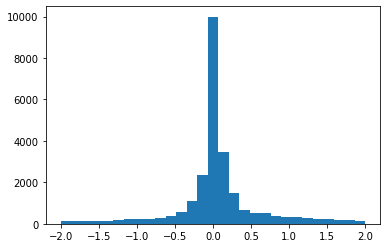

In [78]:
# overall distr
bins = np.linspace(-2, 2, 30)
plt.hist(overall_distr, bins=bins)

## Stacking output (orange) over input (blue) for pT, eta, phi, m

(array([   4.,    8.,    8.,   10.,    8.,   17.,   15.,    5.,   12.,
          22.,   23.,   20.,   24.,   25.,   31.,   34.,   33.,   40.,
          64.,   56.,   75.,   92.,  304.,  435.,  547.,  959., 1243.,
        1843.,  597.,  185.,  100.,   66.,   40.,   25.,   29.,   26.,
          23.,   23.,   10.,   16.,   13.,   12.,    9.,    5.,    6.,
          11.,    6.,    7.,    8.]),
 array([-0.1       , -0.09591837, -0.09183673, -0.0877551 , -0.08367347,
        -0.07959184, -0.0755102 , -0.07142857, -0.06734694, -0.06326531,
        -0.05918367, -0.05510204, -0.05102041, -0.04693878, -0.04285714,
        -0.03877551, -0.03469388, -0.03061224, -0.02653061, -0.02244898,
        -0.01836735, -0.01428571, -0.01020408, -0.00612245, -0.00204082,
         0.00204082,  0.00612245,  0.01020408,  0.01428571,  0.01836735,
         0.02244898,  0.02653061,  0.03061224,  0.03469388,  0.03877551,
         0.04285714,  0.04693878,  0.05102041,  0.05510204,  0.05918367,
         0.06326531,  0

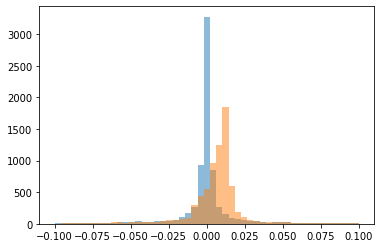

In [79]:
bins = np.linspace(-0.1, 0.1, 50)
plt.hist(px, bins=bins,alpha=0.5)
plt.hist(px_pred, bins=bins,alpha=0.5)

(array([7.000e+00, 7.000e+00, 7.000e+00, 4.000e+00, 6.000e+00, 1.200e+01,
        9.000e+00, 8.000e+00, 1.300e+01, 1.600e+01, 1.500e+01, 1.500e+01,
        2.100e+01, 2.100e+01, 2.300e+01, 3.600e+01, 3.400e+01, 4.300e+01,
        9.200e+01, 1.640e+02, 8.110e+02, 2.424e+03, 1.598e+03, 5.320e+02,
        2.030e+02, 1.510e+02, 1.300e+02, 1.570e+02, 1.600e+02, 1.410e+02,
        8.400e+01, 4.600e+01, 3.700e+01, 2.800e+01, 2.900e+01, 1.200e+01,
        1.900e+01, 1.600e+01, 2.400e+01, 1.400e+01, 1.400e+01, 1.300e+01,
        1.000e+01, 2.000e+00, 5.000e+00, 6.000e+00, 5.000e+00, 1.000e+00,
        6.000e+00]),
 array([-0.1       , -0.09591837, -0.09183673, -0.0877551 , -0.08367347,
        -0.07959184, -0.0755102 , -0.07142857, -0.06734694, -0.06326531,
        -0.05918367, -0.05510204, -0.05102041, -0.04693878, -0.04285714,
        -0.03877551, -0.03469388, -0.03061224, -0.02653061, -0.02244898,
        -0.01836735, -0.01428571, -0.01020408, -0.00612245, -0.00204082,
         0.00204082,  

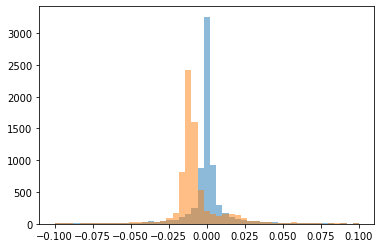

In [80]:
bins = np.linspace(-0.1, 0.1, 50)
plt.hist(py, bins=bins,alpha=0.5)
plt.hist(py_pred, bins=bins,alpha=0.5)

(array([  14.,   30.,   24.,   24.,   49.,   28.,   34.,   40.,   29.,
          34.,   29.,   45.,   55.,   28.,   28.,   31.,   36.,   53.,
         209.,  224.,  145.,  213.,  334.,  742., 1922., 1087.,  378.,
         252.,  142.,  127.,   95.,  234.,   54.,   56.,   31.,   33.,
          25.,   21.,   34.,   19.,   24.,   27.,   14.,   26.,   23.,
          15.,   11.,   18.,   18.]),
 array([-0.5       , -0.47959184, -0.45918367, -0.43877551, -0.41836735,
        -0.39795918, -0.37755102, -0.35714286, -0.33673469, -0.31632653,
        -0.29591837, -0.2755102 , -0.25510204, -0.23469388, -0.21428571,
        -0.19387755, -0.17346939, -0.15306122, -0.13265306, -0.1122449 ,
        -0.09183673, -0.07142857, -0.05102041, -0.03061224, -0.01020408,
         0.01020408,  0.03061224,  0.05102041,  0.07142857,  0.09183673,
         0.1122449 ,  0.13265306,  0.15306122,  0.17346939,  0.19387755,
         0.21428571,  0.23469388,  0.25510204,  0.2755102 ,  0.29591837,
         0.31632653,  0

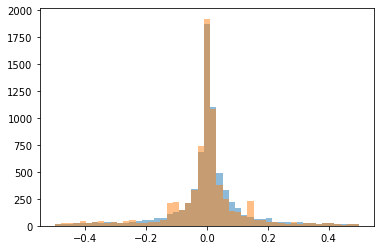

In [81]:
bins = np.linspace(-0.5, 0.5, 50)
plt.hist(pz, bins=bins,alpha=0.5)
plt.hist(pz_pred, bins=bins,alpha=0.5)

(array([   0.,    0.,    0., 2154., 2322.,  488.,  328.,  308.,  329.,
         106.,  116.,   86.,   76.,   96.,   79.,   74.,   66.,   69.,
          57.,   57.,   51.,   27.,   39.,   22.,   25.,   21.,   21.,
          11.,   12.,   20.,   11.,   18.,   23.,   20.,    7.,   10.,
          15.,   19.,   15.,    8.,    9.,   12.,   12.,   19.,    7.,
          14.,    7.,   12.,   15.]),
 array([-0.55      , -0.53265306, -0.51530612, -0.49795918, -0.48061224,
        -0.46326531, -0.44591837, -0.42857143, -0.41122449, -0.39387755,
        -0.37653061, -0.35918367, -0.34183673, -0.3244898 , -0.30714286,
        -0.28979592, -0.27244898, -0.25510204, -0.2377551 , -0.22040816,
        -0.20306122, -0.18571429, -0.16836735, -0.15102041, -0.13367347,
        -0.11632653, -0.09897959, -0.08163265, -0.06428571, -0.04693878,
        -0.02959184, -0.0122449 ,  0.00510204,  0.02244898,  0.03979592,
         0.05714286,  0.0744898 ,  0.09183673,  0.10918367,  0.12653061,
         0.14387755,  0

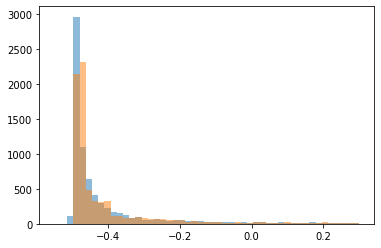

In [82]:
bins = np.linspace(-0.55,0.3, 50)
plt.hist(e, bins=bins,alpha=0.5)
plt.hist(e_pred, bins=bins,alpha=0.5)

In [83]:
d_px = [row[0] for row in distr]
d_py = [row[1] for row in distr]
d_pz = [row[2] for row in distr]
d_e = [row[3] for row in distr]

## Distribution of (input - output) / input

In [84]:
bins = np.linspace(-2, 2, 30)

(array([ 56.,  47.,  49.,  49.,  64.,  63.,  72.,  73.,  73.,  86.,  94.,
        118., 168., 265., 422., 446., 304., 242., 215., 210., 188., 148.,
        128., 110., 109.,  98.,  93.,  84.,  66.]),
 array([-2.        , -1.86206897, -1.72413793, -1.5862069 , -1.44827586,
        -1.31034483, -1.17241379, -1.03448276, -0.89655172, -0.75862069,
        -0.62068966, -0.48275862, -0.34482759, -0.20689655, -0.06896552,
         0.06896552,  0.20689655,  0.34482759,  0.48275862,  0.62068966,
         0.75862069,  0.89655172,  1.03448276,  1.17241379,  1.31034483,
         1.44827586,  1.5862069 ,  1.72413793,  1.86206897,  2.        ]),
 <a list of 29 Patch objects>)

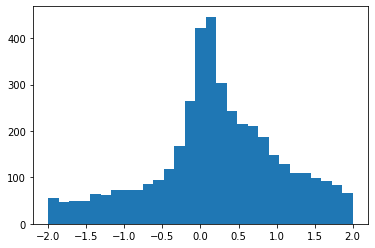

In [85]:
plt.hist(d_px, bins=bins)

(array([ 35.,  39.,  49.,  56.,  54.,  53.,  69.,  60.,  65.,  76.,  86.,
        116., 114., 234., 466., 388., 249., 173., 163., 185., 156., 154.,
        151., 118.,  93.,  83.,  92.,  81.,  60.]),
 array([-2.        , -1.86206897, -1.72413793, -1.5862069 , -1.44827586,
        -1.31034483, -1.17241379, -1.03448276, -0.89655172, -0.75862069,
        -0.62068966, -0.48275862, -0.34482759, -0.20689655, -0.06896552,
         0.06896552,  0.20689655,  0.34482759,  0.48275862,  0.62068966,
         0.75862069,  0.89655172,  1.03448276,  1.17241379,  1.31034483,
         1.44827586,  1.5862069 ,  1.72413793,  1.86206897,  2.        ]),
 <a list of 29 Patch objects>)

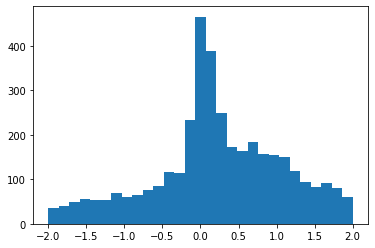

In [86]:
plt.hist(d_py, bins=bins)

(array([  20.,   30.,   30.,   31.,   27.,   40.,   56.,   84.,   72.,
          91.,  141.,  232.,  617., 1170., 1903., 2337.,  850.,  208.,
         128.,  112.,   49.,   35.,   39.,   24.,   23.,   24.,    9.,
          13.,   13.]),
 array([-2.        , -1.86206897, -1.72413793, -1.5862069 , -1.44827586,
        -1.31034483, -1.17241379, -1.03448276, -0.89655172, -0.75862069,
        -0.62068966, -0.48275862, -0.34482759, -0.20689655, -0.06896552,
         0.06896552,  0.20689655,  0.34482759,  0.48275862,  0.62068966,
         0.75862069,  0.89655172,  1.03448276,  1.17241379,  1.31034483,
         1.44827586,  1.5862069 ,  1.72413793,  1.86206897,  2.        ]),
 <a list of 29 Patch objects>)

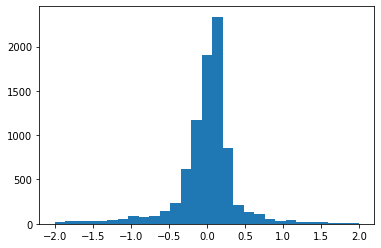

In [87]:
plt.hist(d_pz, bins=bins)

(array([7.000e+00, 1.000e+00, 5.000e+00, 6.000e+00, 8.000e+00, 5.000e+00,
        1.600e+01, 1.900e+01, 1.500e+01, 1.800e+01, 4.900e+01, 8.300e+01,
        1.910e+02, 6.930e+02, 7.205e+03, 3.120e+02, 8.600e+01, 2.800e+01,
        1.300e+01, 1.100e+01, 7.000e+00, 3.000e+00, 5.000e+00, 8.000e+00,
        5.000e+00, 3.000e+00, 3.000e+00, 2.000e+00, 1.000e+00]),
 array([-2.        , -1.86206897, -1.72413793, -1.5862069 , -1.44827586,
        -1.31034483, -1.17241379, -1.03448276, -0.89655172, -0.75862069,
        -0.62068966, -0.48275862, -0.34482759, -0.20689655, -0.06896552,
         0.06896552,  0.20689655,  0.34482759,  0.48275862,  0.62068966,
         0.75862069,  0.89655172,  1.03448276,  1.17241379,  1.31034483,
         1.44827586,  1.5862069 ,  1.72413793,  1.86206897,  2.        ]),
 <a list of 29 Patch objects>)

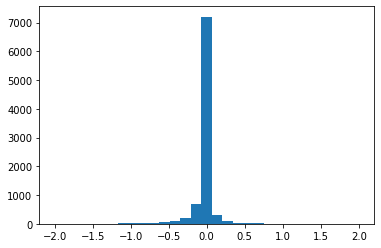

In [88]:
plt.hist(d_e, bins=bins)